# Importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import yaml
import gc
 
from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.Qsamplings import get_pointing, equ2gal, QubicSampling
from qubic.lib.Instrument.Qacquisition import QubicAcquisition, QubicDualBand
from qubic.lib.Instrument.Qinstrument import compute_freq
from qubic.lib.Qscene import QubicScene

from qubic.lib.MapMaking.Qcg_test_for_atm import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, AdditionOperator, BlockDiagonalOperator, BlockRowOperator, DiagonalOperator, ReshapeOperator, DenseOperator, BlockColumnOperator, IdentityOperator, PackOperator, CompositionOperator, DenseBlockDiagonalOperator, BlockDiagonalOperator

from pysimulators.interfaces.healpy import Spherical2HealpixOperator, HealpixConvolutionGaussianOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank() 

%matplotlib inline

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 
    
np.random.seed(params['seed'])

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

npix = hp.nside2npix(params['nside'])

# Scanning Strategy

## Galactic Coordinates

In [4]:
### Random pointing
qubic_dict['random_pointing'] = True
qubic_dict['date_obs'] = '2016-01-01T00:00:00'

### Sweepingpointing
qubic_dict['sweeping_pointing'] = False
qubic_dict['fix_azimuth']['apply'] = False 

# qubic_dict['angspeed'] = 0.4
# qubic_dict['delta_az'] = 20
# qubic_dict['nsweeps_per_elevation'] = 5
# qubic_dict['period'] = 1e-15
# qubic_dict['duration'] = 1
# npointings = 3600 * t_obs / period

### Repeat pointing
qubic_dict['repeat_pointing'] = False

qubic_dict['fix_azimuth']['apply'] = False

q_sampling_gal = get_pointing(qubic_dict)
qubic_patch = np.array([0, -57])
center_gal = equ2gal(qubic_patch[0], qubic_patch[1])
center_local = np.array([np.mean(q_sampling_gal.azimuth), np.mean(q_sampling_gal.elevation)])
print(q_sampling_gal)

QubicSampling((8000,), 
    index=[   0    1    2 ... 7997 7998 7999],
    angle_hwp=[45  0 60 ... 60 30 75],
    azimuth=[208.29015171 217.96497746 230.83513248 ... 225.74353162 206.6717,
    elevation=[60.65556465 45.65114436 52.17153293 ... 36.34393655 34.45603351
,
    equatorial=[[ 13.03967463 -48.65528162]
 [348.39776565 -52.71974346]
 [353.3,
    galactic=[[302.60752807 -68.47251439]
 [331.70496724 -58.59529355]
 [343.5,
    masked=False,
    pitch=[278.41651106  98.25128209 303.95284612 ... 160.99494904 163.2270)


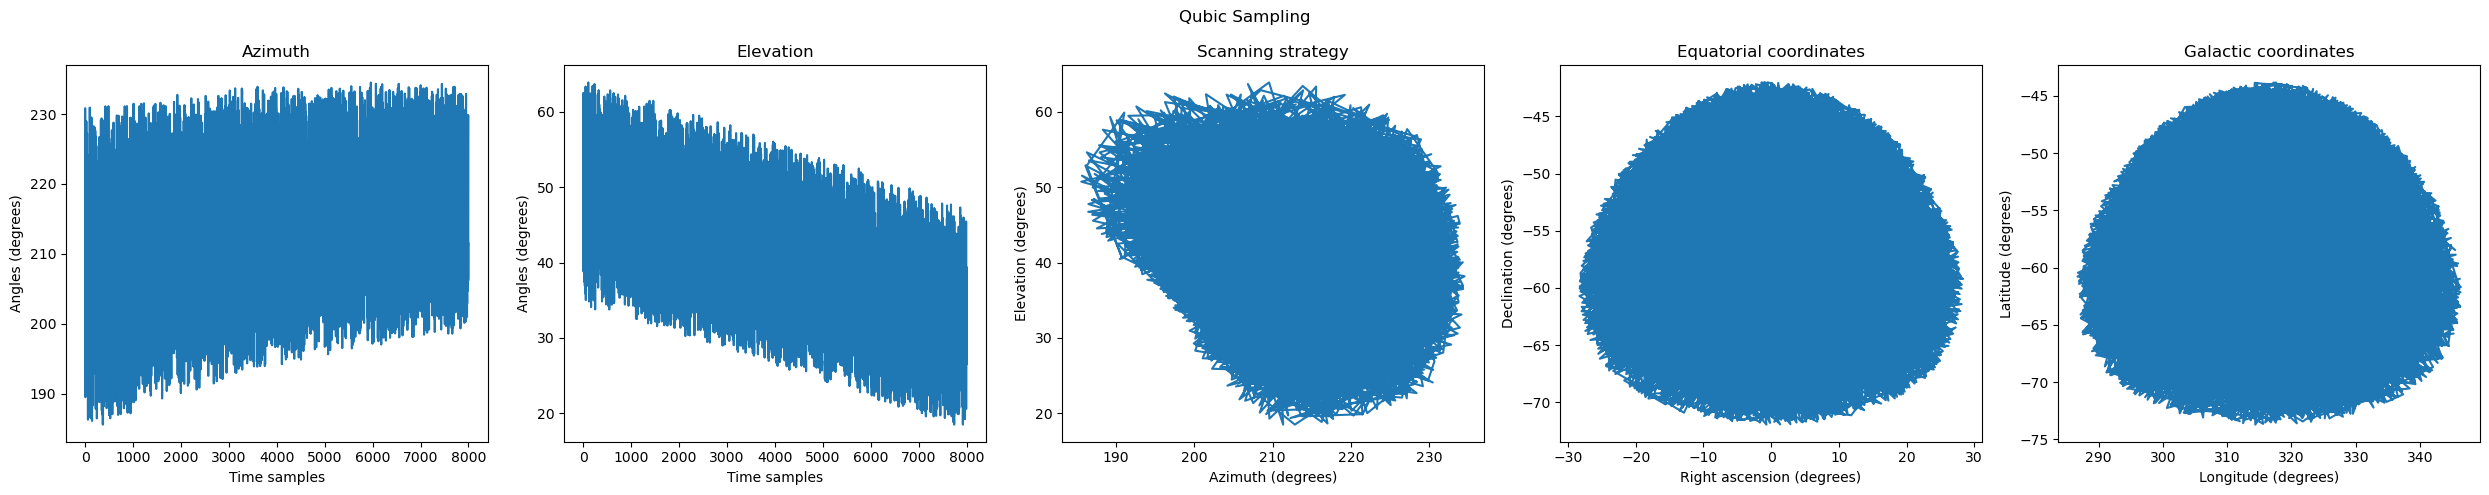

In [5]:
az, el = q_sampling_gal.azimuth, q_sampling_gal.elevation

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# Azimuth plot
axs[0].plot(az)
axs[0].set_title("Azimuth")
axs[0].set_xlabel("Time samples")
axs[0].set_ylabel("Angles (degrees)")

# Elevation plot
axs[1].plot(el)
axs[1].set_title("Elevation")
axs[1].set_xlabel("Time samples")
axs[1].set_ylabel("Angles (degrees)")

# Scanning strategy plot
axs[2].plot(az, el)
axs[2].set_title("Scanning strategy")
axs[2].set_xlabel("Azimuth (degrees)")
axs[2].set_ylabel("Elevation (degrees)")

# Equatorial coordinates plot
axs[3].plot((q_sampling_gal.equatorial[:, 0] + 180) % 360 - 180, q_sampling_gal.equatorial[:, 1])
axs[3].set_title("Equatorial coordinates")
axs[3].set_xlabel("Right ascension (degrees)")
axs[3].set_ylabel("Declination (degrees)")

# Galactic coordinates plot
axs[4].plot(q_sampling_gal.galactic[:, 0], q_sampling_gal.galactic[:, 1])
axs[4].set_title("Galactic coordinates")
axs[4].set_xlabel("Longitude (degrees)")
axs[4].set_ylabel("Latitude (degrees)")

fig.suptitle("Qubic Sampling")
plt.tight_layout()
plt.show()

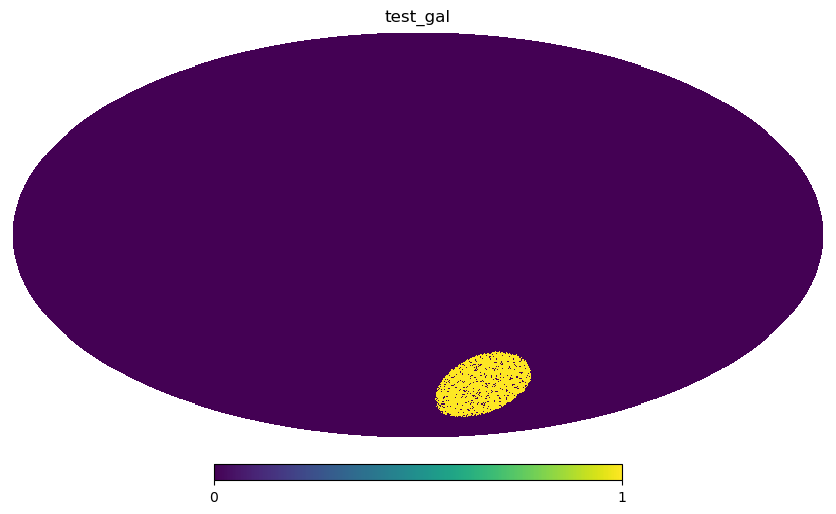

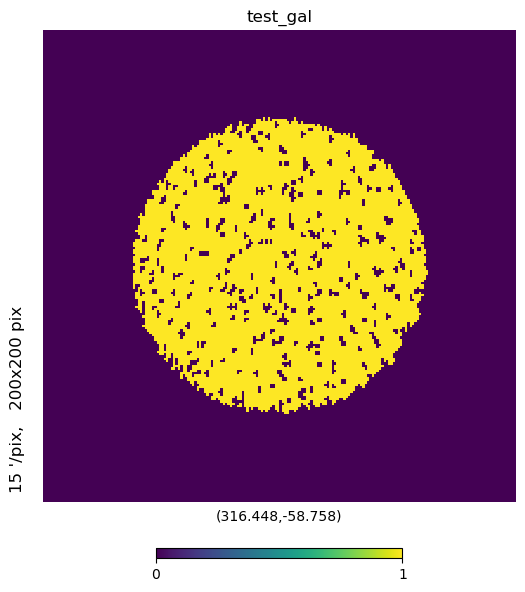

In [6]:
test_gal = np.zeros(hp.nside2npix(params['nside']))

index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians(q_sampling_gal.galactic)), dtype='int')
test_gal[index] = 1
hp.mollview(test_gal, title='test_gal', cmap='viridis')
hp.gnomview(test_gal, title='test_gal', cmap='viridis', reso=15, rot=center_gal)

## Local Coordinates

In [7]:
q_sampling_local = QubicSampling(q_sampling_gal.index.size, #int(np.ceil(qubic_dict['duration']*3600/qubic_dict['period'])),
                           date_obs = qubic_dict['date_obs'],
                           period = qubic_dict['period'],
                           latitude = qubic_dict['latitude'],
                           longitude = qubic_dict['longitude'])

q_sampling_local.azimuth = q_sampling_gal.azimuth
q_sampling_local.elevation = q_sampling_gal.elevation
q_sampling_local.pitch = q_sampling_gal.pitch
q_sampling_local.angle_hwp = q_sampling_gal.angle_hwp

q_sampling_local.fix_az = True

213.29685578145006 40.65214572820172


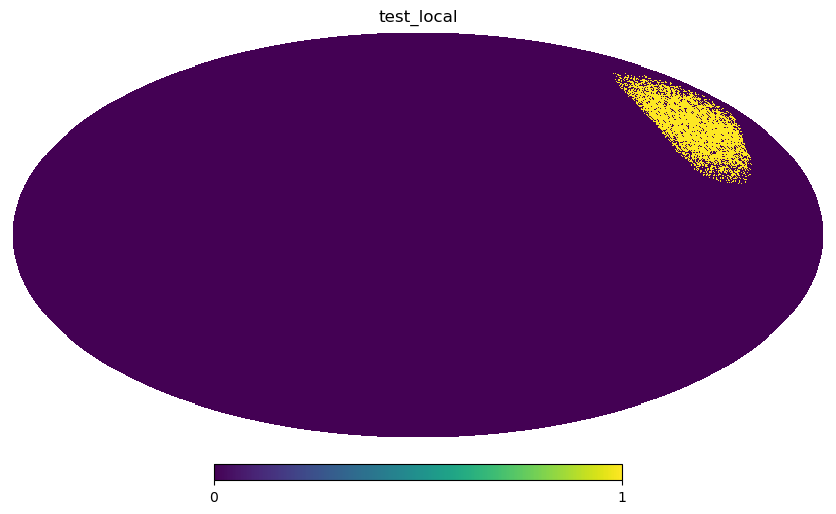

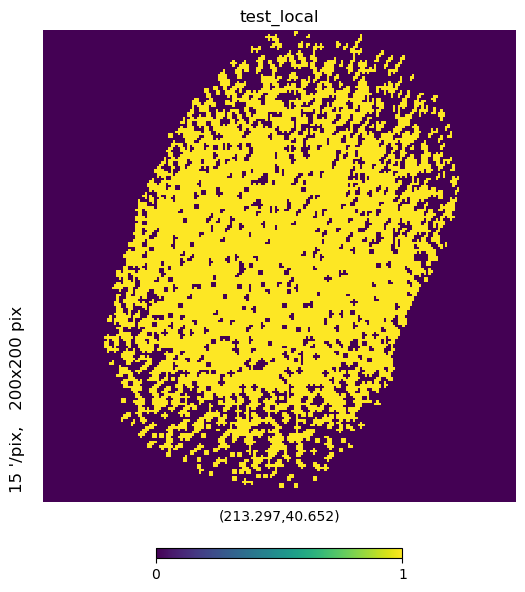

In [8]:
test_gal = np.zeros(hp.nside2npix(params['nside']))

index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians([q_sampling_local.azimuth, q_sampling_local.elevation]).T), dtype='int')
test_gal[index] = 1
hp.mollview(test_gal, title='test_local', cmap='viridis')
hp.gnomview(test_gal, title='test_local', cmap='viridis', reso=15, rot=(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation)))

print(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation))

# Input Maps

## CMB

(8, 196608, 3)


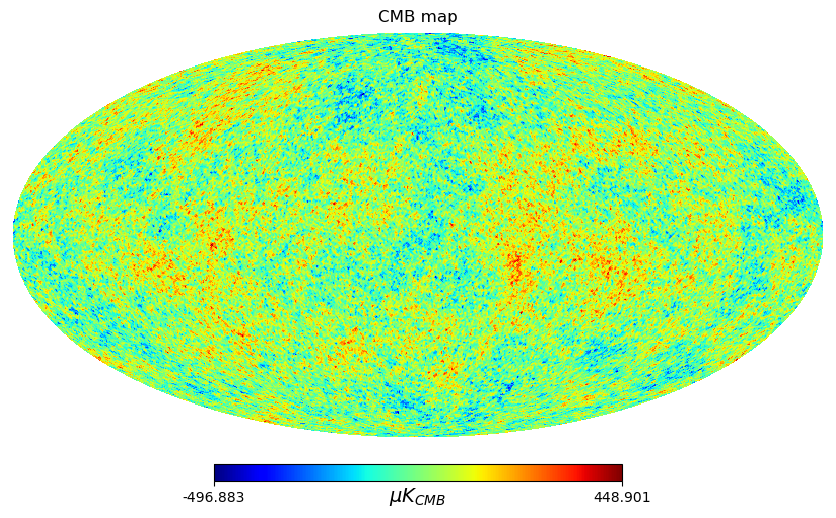

In [9]:
# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, params['nside'], new=True, verbose=False).T

cmb_maps = np.ones((params['nsub_in'], hp.nside2npix(params['nside']), 3))
cmb_maps *= cmb_map[None]
print(cmb_maps.shape)

hp.mollview(cmb_map[:, 0], cmap='jet', title='CMB map', unit=r'$µK_{CMB}$')

## Atmosphere

In [10]:
atm_maps = np.zeros((cmb_maps.shape))

mean_rho = atm.mean_water_vapor_density
water_vapor_map = atm.get_water_vapor_density_2d_map(mean_rho, flat=False)
for i in range(params['nsub_in']):
    atm_maps[i, :, 0] = water_vapor_map
atm_maps = atm.get_temp_maps(atm_maps)
atm_maps[..., 0] -= np.mean(atm_maps[..., 0], axis=1)[:, None]
atm_maps[..., 1] *= 0
atm_maps[..., 2] *= 0

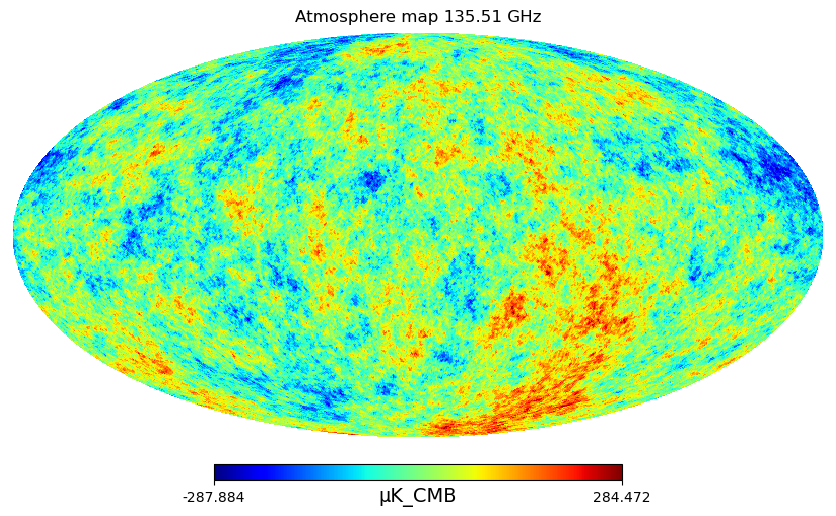

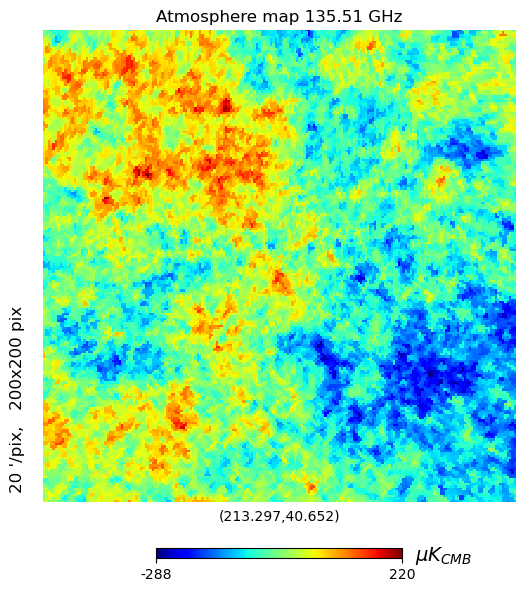

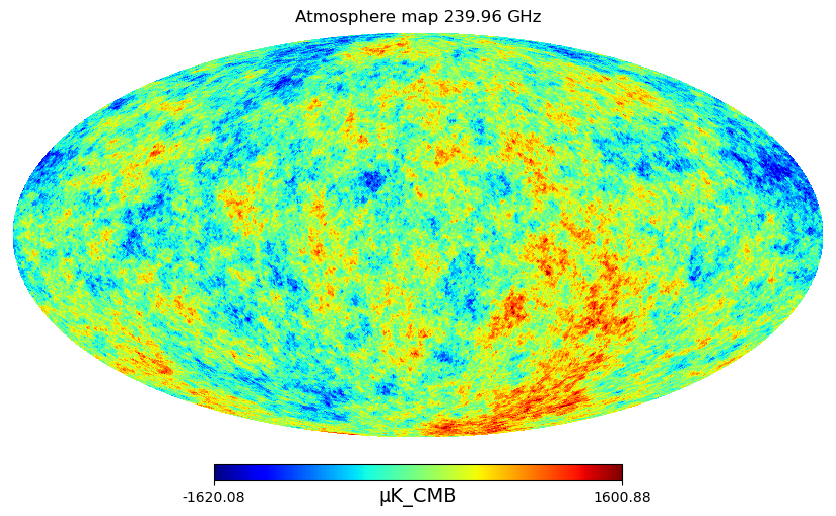

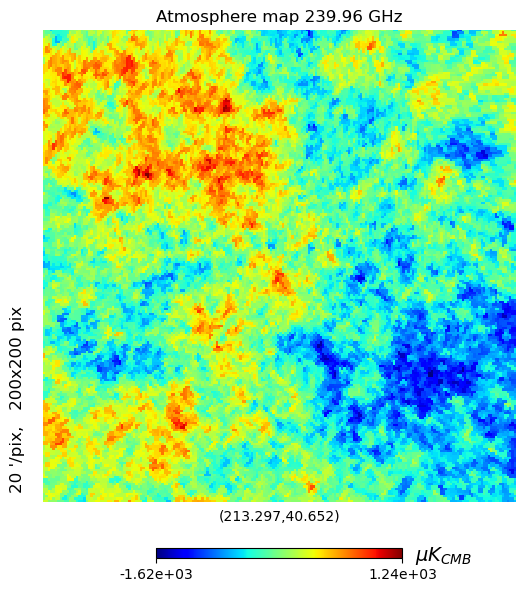

In [11]:
index_nu = 0
hp.mollview(atm_maps[index_nu, :, 0] ,cmap='jet', unit='µK_CMB', title='Atmosphere map {:.2f} GHz'.format(atm.frequencies[index_nu]))
hp.gnomview(atm_maps[index_nu, :, 0], rot=center_local, reso=20, title='Atmosphere map {:.2f} GHz'.format(atm.frequencies[index_nu]), unit=r'$µK_{CMB}$', cmap='jet')

index_nu = -1
hp.mollview(atm_maps[index_nu, :, 0] ,cmap='jet', unit='µK_CMB', title='Atmosphere map {:.2f} GHz'.format(atm.frequencies[index_nu]))
hp.gnomview(atm_maps[index_nu, :, 0], rot=center_local, reso=20, title='Atmosphere map {:.2f} GHz'.format(atm.frequencies[index_nu]), unit=r'$µK_{CMB}$', cmap='jet')

## Apply convolutions - Input Maps

In [12]:
fwhm_synthbeam150 = 0.006853589624526168

_, _, filter_nus150, deltas150, _, _ = compute_freq(
        150, int(params["nsub_in"] / 2), relative_bandwidth=qubic_dict["filter_relative_bandwidth"], frequency_spacing="log")
_, _, filter_nus220, deltas220, _, _ = compute_freq(
        220, int(params["nsub_in"] / 2), relative_bandwidth=qubic_dict["filter_relative_bandwidth"], frequency_spacing="log")
        
nus_tod = np.concatenate((filter_nus150, filter_nus220)) * 1e9
fwhm_tod = fwhm_synthbeam150 * 150e9 / nus_tod

In [13]:
for isub in range(nus_tod.size):
    C = HealpixConvolutionGaussianOperator(fwhm = fwhm_tod[i])
    atm_maps[isub] = C(atm_maps[isub])
    cmb_maps[isub] = C(cmb_maps[isub])

## Input Maps

In [14]:
input_maps = np.zeros((2*params["nsub_in"], hp.nside2npix(params["nside"]), 3))

input_maps[:params["nsub_in"]] = cmb_maps
input_maps[params["nsub_in"]:] = atm_maps

## True maps

In [42]:
### Build Expected Atm Maps
true_maps = np.zeros((2, 12*params['nside']**2, 3))
true_atm_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_cmb_maps = np.zeros((params["nrec"], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])

# Build the reconstructed maps and frequency by taking the mean inside each reconstructed frequency band
C = HealpixConvolutionGaussianOperator(fwhm=np.mean(fwhm_tod))
true_maps[0] = C(cmb_map)
true_maps[1] = C(np.mean(atm_maps, axis=0))

min_input = np.min(true_maps, axis=1)
max_input = np.max(true_maps, axis=1)

max = np.max([min_input, max_input], axis=0)
min_input = -max
max_input = max

# Mixing Matrix

In [16]:
MixingMatrix = np.ones((params['nsub_in'], 2))
# Atm mixing matrix
MixingMatrix[:, 1] = atm.temperature * atm.integrated_abs_spectrum

print(MixingMatrix.shape)
print(MixingMatrix[:, 1, None].shape)

(8, 2)
(8, 1)


# Build QUBIC Instances

In [17]:
q_acquisition_local = QubicDualBand(qubic_dict, params["nsub_in"], params["nsub_in"], sampling=q_sampling_local)

q_acquisition_gal = QubicDualBand(qubic_dict, params["nsub_in"], params["nsub_in"], sampling=q_sampling_gal)

Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
I

In [18]:
coverage_gal = q_acquisition_gal.coverage
covnorm_gal = coverage_gal / coverage_gal.max()
seenpix_gal = covnorm_gal > params['coverage_cut']
seenpix_gal_wo_cut = covnorm_gal > 0

coverage_local = q_acquisition_local.coverage
covnorm_local = coverage_local / coverage_local.max()
seenpix_local = covnorm_local > params['coverage_cut']
seenpix_local_wo_cut = covnorm_local > 0

seenpix = np.array([seenpix_gal, seenpix_local])

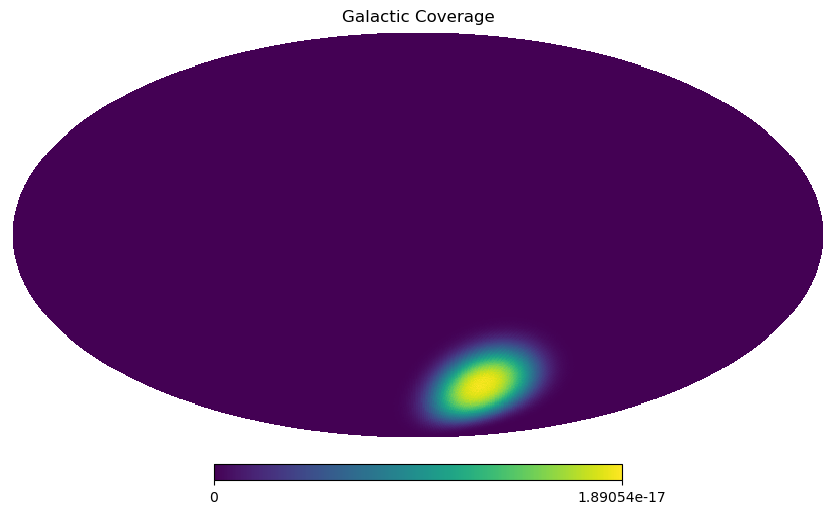

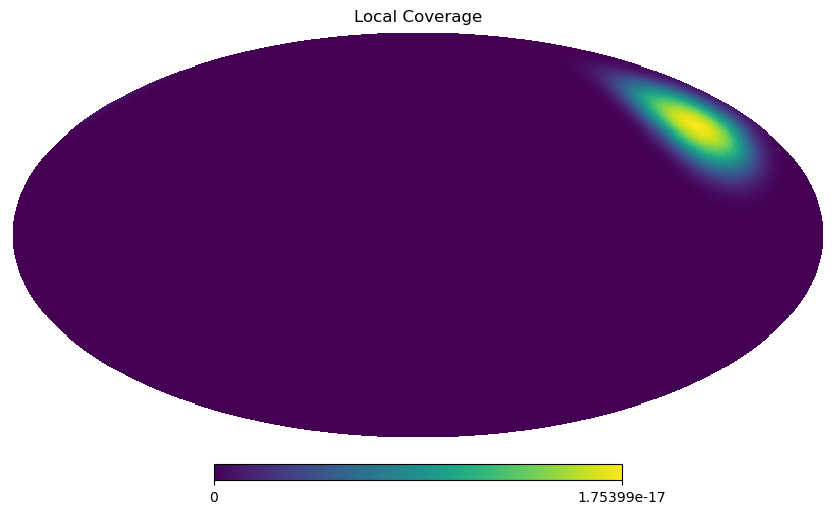

In [19]:
# Test coverage
hp.mollview(coverage_gal, title="Galactic Coverage")
hp.mollview(coverage_local, title="Local Coverage")

# Build QUBIC Operaotors

In [20]:
# Galactic Coordinates

H_gal = q_acquisition_gal.get_operator()
    
invN_gal = q_acquisition_gal.get_invntt_operator(False, False)

print("H_gal", H_gal.shapein, H_gal.shapeout)
print("invN_gal", invN_gal.shapein, invN_gal.shapeout)

H_gal (8, 196608, 3) (1984, 8000)
invN_gal (1984, 8000) (1984, 8000)


In [21]:
# Local Coordinates

H_local = q_acquisition_local.get_operator()

invN_local = q_acquisition_local.get_invntt_operator(False, False)

print("H_local", H_local.shapein, H_local.shapeout)
print("invN_local", invN_local.shapein, invN_local.shapeout)

H_local (8, 196608, 3) (1984, 8000)
invN_local (1984, 8000) (1984, 8000)


In [22]:
### Full MM
R = ReshapeOperator((2*992, params["npointings"]), (params["npointings"]*992*2))

r = ReshapeOperator((npix, 3), (1, npix, 3))
A_gal = DenseOperator(MixingMatrix[:, 0, None], broadcast="rightward", shapein=(1, npix, 3), shapeout=(params['nsub_in'], npix, 3)) * r
A_local = DenseOperator(MixingMatrix[:, 1, None], broadcast="rightward", shapein=(1, npix, 3), shapeout=(params['nsub_in'], npix, 3)) * r

H = BlockRowOperator([H_gal(A_gal), H_local(A_local)], axisin=0) * ReshapeOperator((2, npix, 3), (2 * npix, 3))
print(H.shapein, H.shapeout)

invN = invN_gal
print(invN.shapein, invN.shapeout)

tod = H(true_maps)
print(tod.shape)

(2, 196608, 3) (1984, 8000)
(1984, 8000) (1984, 8000)
(1984, 8000)


In [23]:
print("H", H.shapein, H.shapeout)
print("invN", invN.shapein, invN.shapeout)
print('True maps', true_maps.shape)
print("tod", tod.shape)

H (2, 196608, 3) (1984, 8000)
invN (1984, 8000) (1984, 8000)
True maps (2, 196608, 3)
tod (1984, 8000)


In [ ]:
### Test to verify if tod = tod_gal + tod_local

tod_gal = H_gal(A_gal(true_maps[0]))
tod_local = H_local(A_local(true_maps[1]))

plt.plot(tod.ravel(), label='tod', alpha=0.5)
plt.plot((tod_gal + tod_local).ravel(), label='tod_gal + tod_local', alpha=0.5)
plt.legend()
plt.show()

print("Difference between tod and tod_gal + tod_local : ", np.setdiff1d(tod.ravel(), (tod_gal + tod_local).ravel()))

In [ ]:
stop

# Map-Making

In [24]:
# Ax=b equation to be solve by PCG
A = H.T * invN * H
b = H.T * invN * tod

# I start from an atm map for the CMB and from a cmb map for the atmosphere
x0 = true_maps * 0.

In [25]:
print("A", A.shapein, A.shapeout)
print("Ax", A(x0).shape)
print("b", b.shape)
print("true_maps", true_maps.shape)

A (2, 196608, 3) (2, 196608, 3)
Ax (2, 196608, 3)
b (2, 196608, 3)
true_maps (2, 196608, 3)


In [26]:
# # Build Preconditionner
# no_det = 992

# stacked_dptdp_inv = np.zeros((true_maps.shape[0],12*params['nside']**2))
# stacked_dptdp_inv_nus = np.zeros((params["nsub_in"], npix))

# ### Loop on Maps
# for i_map in range(true_maps.shape[0]):
#     for j_fp in range(2):
#         for k_nu in range(int(params["nsub_in"]/2)):
#             print(k_nu + int(params['nsub_in']/2)*j_fp)
#             ### Extract Operators
#             h = H.operands[i_map].operands[0].operands[j_fp].operands[k_nu]
#             D = h.operands[1]
#             P = h.operands[-1]
#             sh = P.matrix.data.index.shape

#             ### Compute the map P^t P
#             point_per_det = int(sh[0] / no_det)
#             mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
#             sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
#             for det, (start, end) in enumerate(sample_ranges):
#                 indices = P.matrix.data.index[start:end, :]  
#                 weights = P.matrix.data.r11[start:end, :]
#                 flat_indices = indices.ravel()
#                 flat_weights = weights.ravel()

#                 mapPitPi = np.zeros(12 * params['nside']**2)
#                 np.add.at(mapPitPi, flat_indices, flat_weights**2)

#                 mapPtP_perdet_seq[det, :] = mapPitPi
                
#             D_elements = D.data
#             D_sq = D_elements**2
#             mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
#             dptdp = mapPtP_seq_scaled.sum(axis = 0)
#             dptdp_inv = 1 / dptdp
#             dptdp_inv[np.isinf(dptdp_inv)] = 0.
            
#             stacked_dptdp_inv_nus[k_nu + int(params['nsub_in']/2)*j_fp] = dptdp_inv
                
#     stacked_dptdp_inv[i_map] = np.mean(stacked_dptdp_inv_nus, axis=0)

# M = BlockDiagonalOperator( \
#                     [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
#                     new_axisin=0)

In [27]:
# Run PCG

seenpix_pcg =  np.array([seenpix_gal, seenpix_local])

algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=1000,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix_pcg,
    input=true_maps,
)
try:
    result = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    result = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 2.6154e-01 8.36488 [15.96582061  0.34706134  0.38437506 45.05577197  0.08143182  0.0756052 ]
   2: 1.4130e-01 7.56339 [15.13989145  0.48193494  0.52158647 43.9394673   0.14293578  0.13832293]
   3: 8.3307e-02 8.32964 [13.88436153  0.66700505  0.68183122 42.47745634  0.23753668  0.24868567]
   4: 6.3755e-02 8.49058 [12.46893774  0.86435136  0.84930822 40.28842087  0.38142734  0.42676583]
   5: 6.7410e-02 8.18816 [11.28819352  0.95643038  0.93475549 38.76310329  0.50357995  0.56527852]
   6: 4.4447e-02 7.01219 [10.81446783  1.087143    1.01958532 36.70567249  0.67312868  0.75038117]
   7: 3.2467e-02 8.35782 [10.15691772  1.08724789  1.00382334 34.70135693  0.85011989  0.95021908]
   8: 2.2840e-02 8.38577 [ 9.24457762  0.98889909  0.96443621 32.63018322  1.01491406  1.14373632]
   9: 2.2610e-02 8.25075 [ 8.45542849  0.90463713  0.8980115  30.52283129  1.12497518  1.26617322]
  10: 2.0849e-02 7.08711 [ 7.64965881  0.87288756  0.88964686 28.76171341  1.2016963 

Text(0, 0.5, 'Convergence')

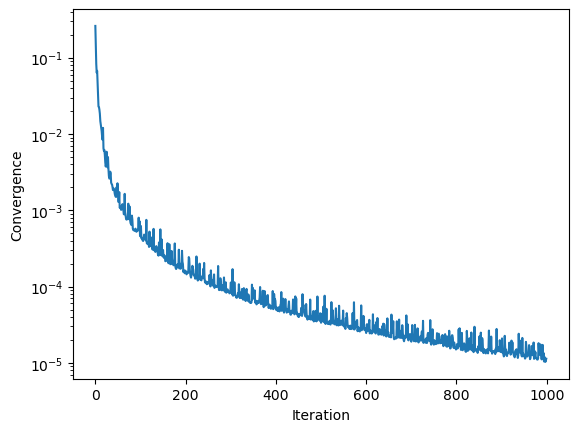

In [28]:
plt.plot(result['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

In [29]:
input = true_maps
output = result['x']
residual = output - input

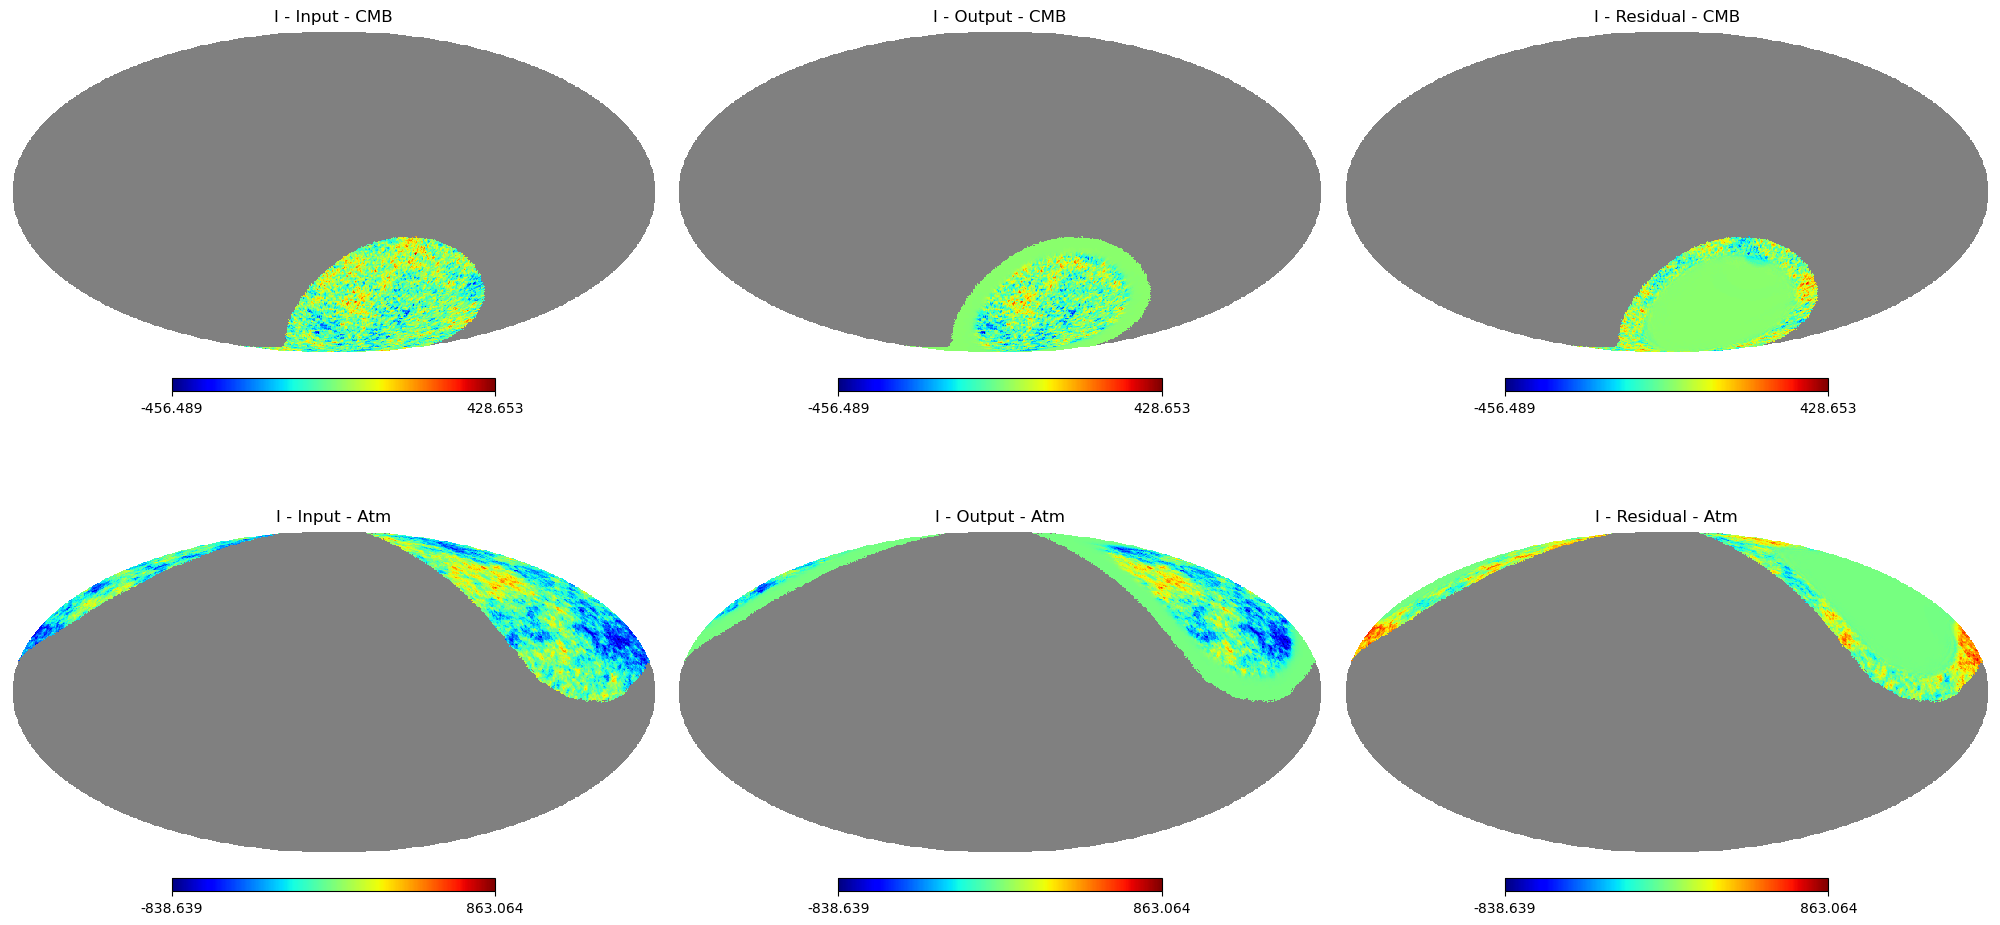

In [30]:
plt.figure(figsize=(20, 10))
k=1

istk = 0
stk = ['I', 'Q', 'U']

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        input[imap, ~seenpix_gal_wo_cut, :] = hp.UNSEEN
        output[imap, ~seenpix_gal_wo_cut, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal_wo_cut, :] = hp.UNSEEN
    else:
        map = "Atm"
        input[imap, ~seenpix_local_wo_cut, :] = hp.UNSEEN
        output[imap, ~seenpix_local_wo_cut, :] = hp.UNSEEN
        residual[imap, ~seenpix_local_wo_cut, :] = hp.UNSEEN
    
    hp.mollview(input[imap, :, istk],min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.mollview(output[imap, :, istk],min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.mollview(residual[imap, :, istk],min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

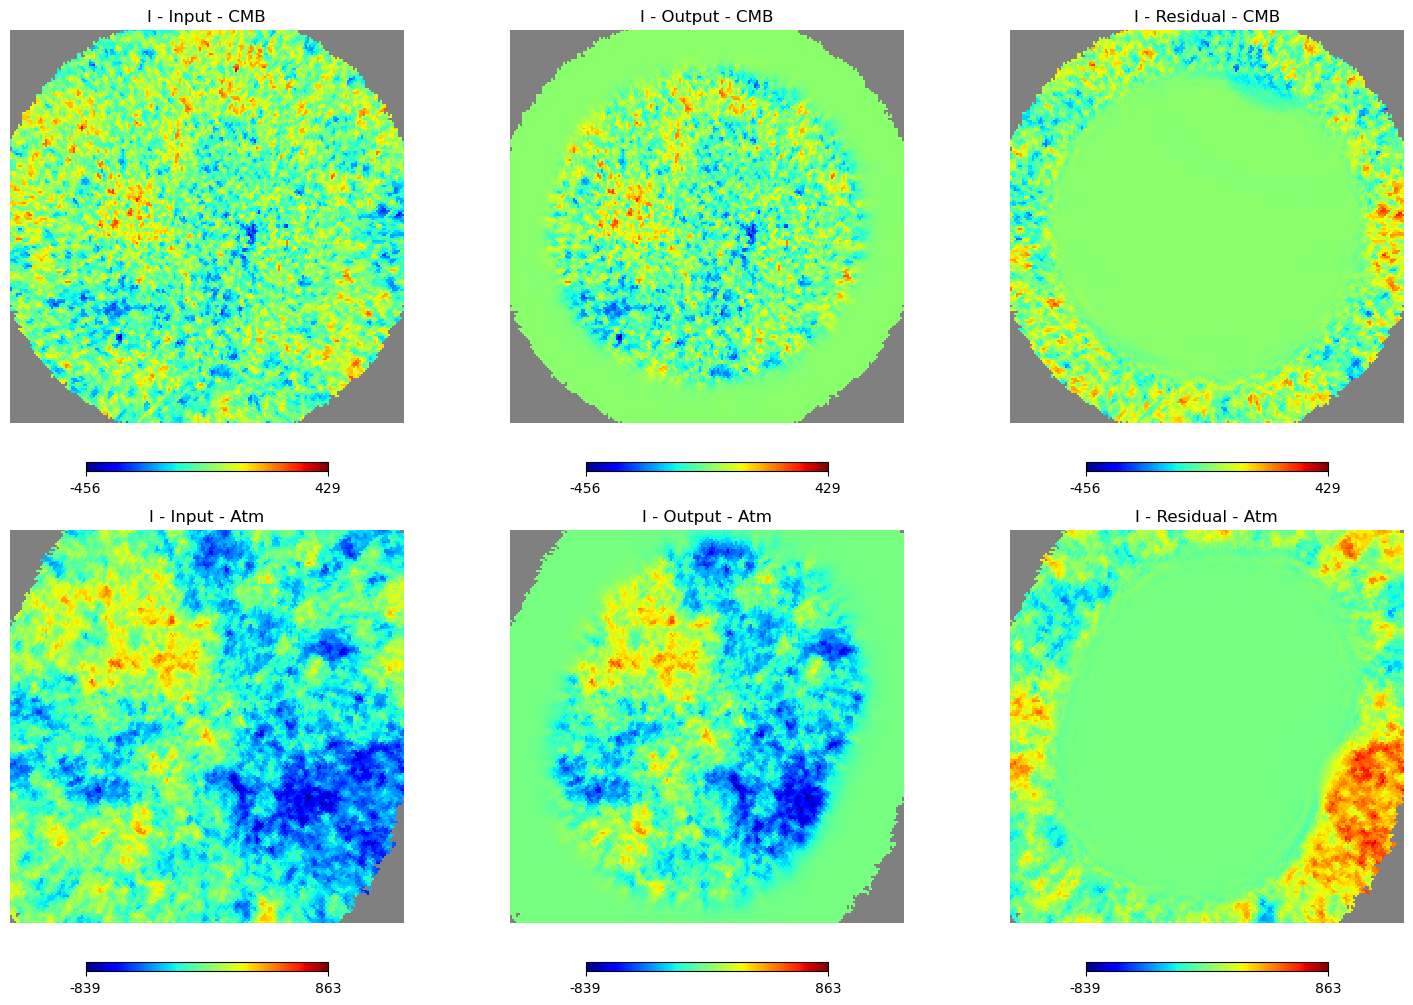

In [31]:
plt.figure(figsize=(15, 10))
k=1

istk = 0
stk = ['I', 'Q', 'U']

reso = 25

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
    else:
        map = "Atm"
        center = center_local
    
    hp.gnomview(input[imap, :, istk],reso=reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso=reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso=reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

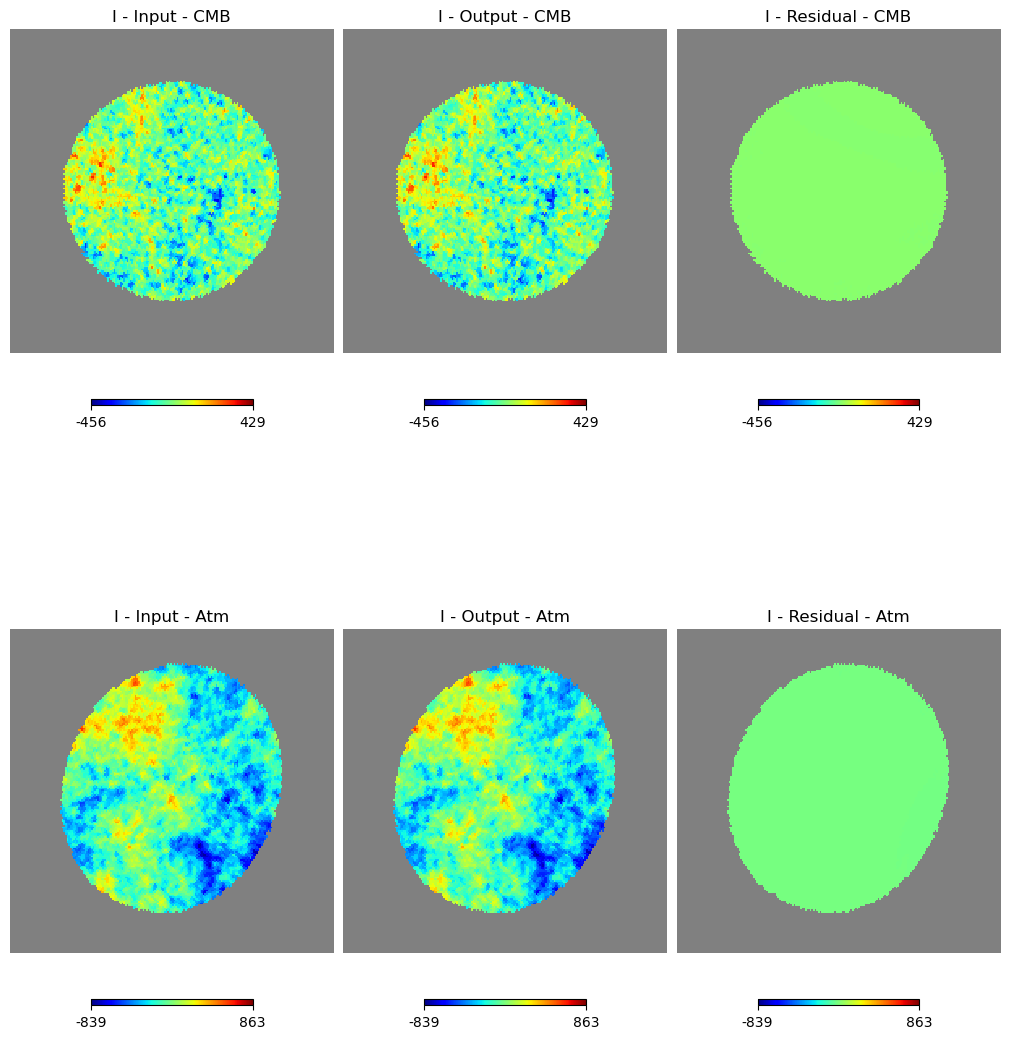

In [32]:
plt.figure(figsize=(10, 12))
k=1

istk = 0
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
        input[imap, ~seenpix_gal, :] = hp.UNSEEN
        output[imap, ~seenpix_gal, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal, :] = hp.UNSEEN
    else:
        map = "Atm"
        center = center_local
        input[imap, ~seenpix_local, :] = hp.UNSEEN
        output[imap, ~seenpix_local, :] = hp.UNSEEN
        residual[imap, ~seenpix_local, :] = hp.UNSEEN
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

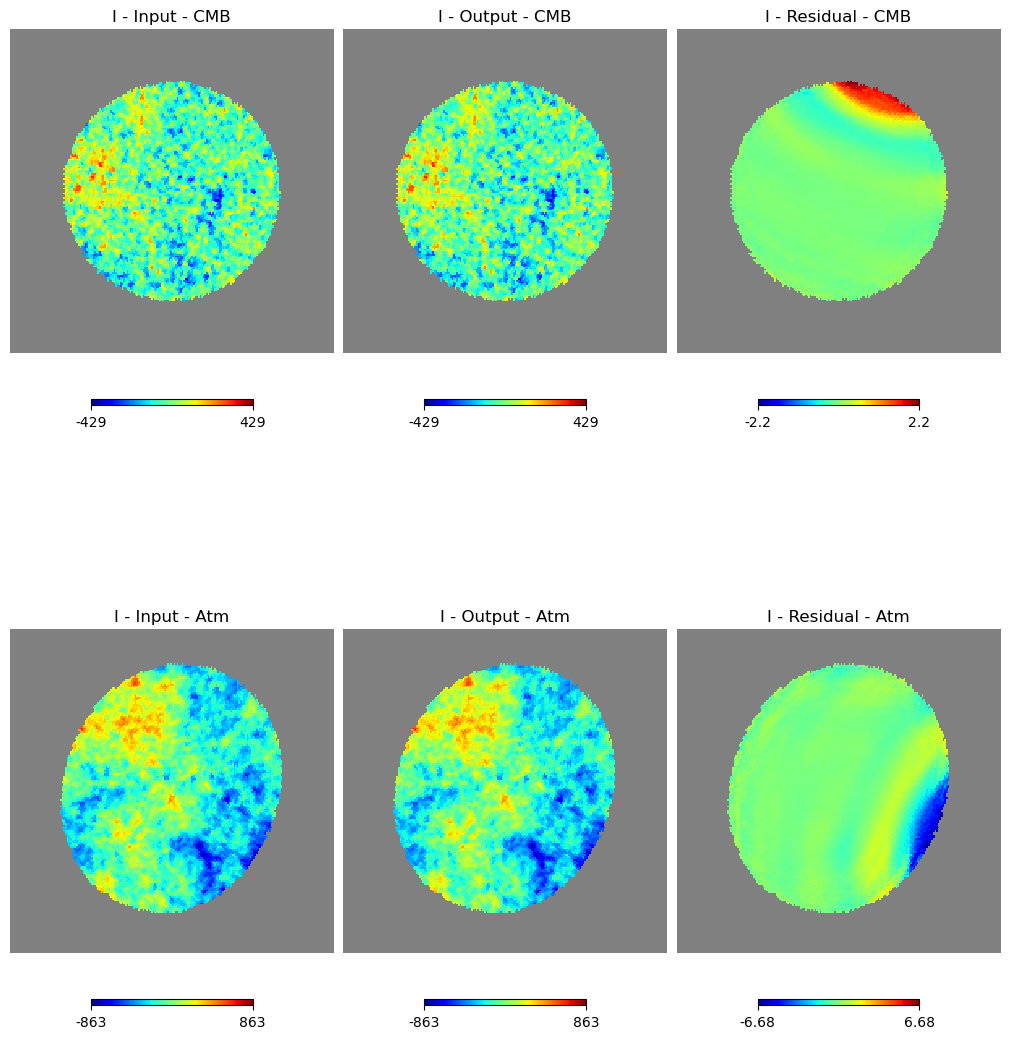

In [43]:
plt.figure(figsize=(10, 12))
k=1

istk = 0
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
        input[imap, ~seenpix_gal, :] = hp.UNSEEN
        output[imap, ~seenpix_gal, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal, :] = hp.UNSEEN
    else:
        map = "Atm"
        center = center_local
        input[imap, ~seenpix_local, :] = hp.UNSEEN
        output[imap, ~seenpix_local, :] = hp.UNSEEN
        residual[imap, ~seenpix_local, :] = hp.UNSEEN
        
    min_res = np.min(residual[imap, seenpix[imap], istk])
    max_res = np.max(residual[imap, seenpix[imap], istk])
    range_hp = np.max([-min_res, max_res])
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, min=-range_hp, max=range_hp, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

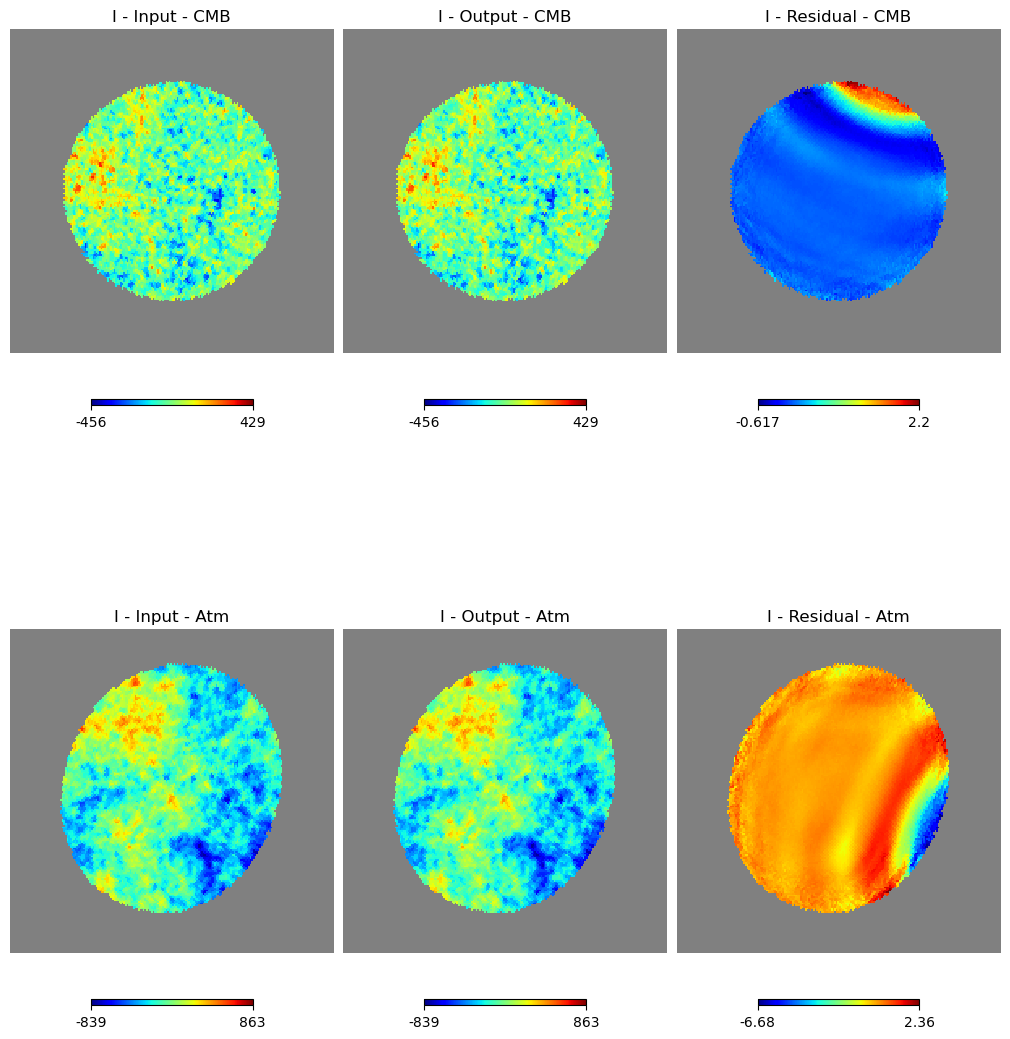

In [34]:
plt.figure(figsize=(10, 12))
k=1

istk = 0
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
        input[imap, ~seenpix_gal, :] = hp.UNSEEN
        output[imap, ~seenpix_gal, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal, :] = hp.UNSEEN
    else:
        map = "Atm"
        center = center_local
        input[imap, ~seenpix_local, :] = hp.UNSEEN
        output[imap, ~seenpix_local, :] = hp.UNSEEN
        residual[imap, ~seenpix_local, :] = hp.UNSEEN
        
    min_res = np.min(residual[imap, seenpix[imap], istk])
    max_res = np.max(residual[imap, seenpix[imap], istk])
    range_hp = np.max([-min_res, max_res])
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

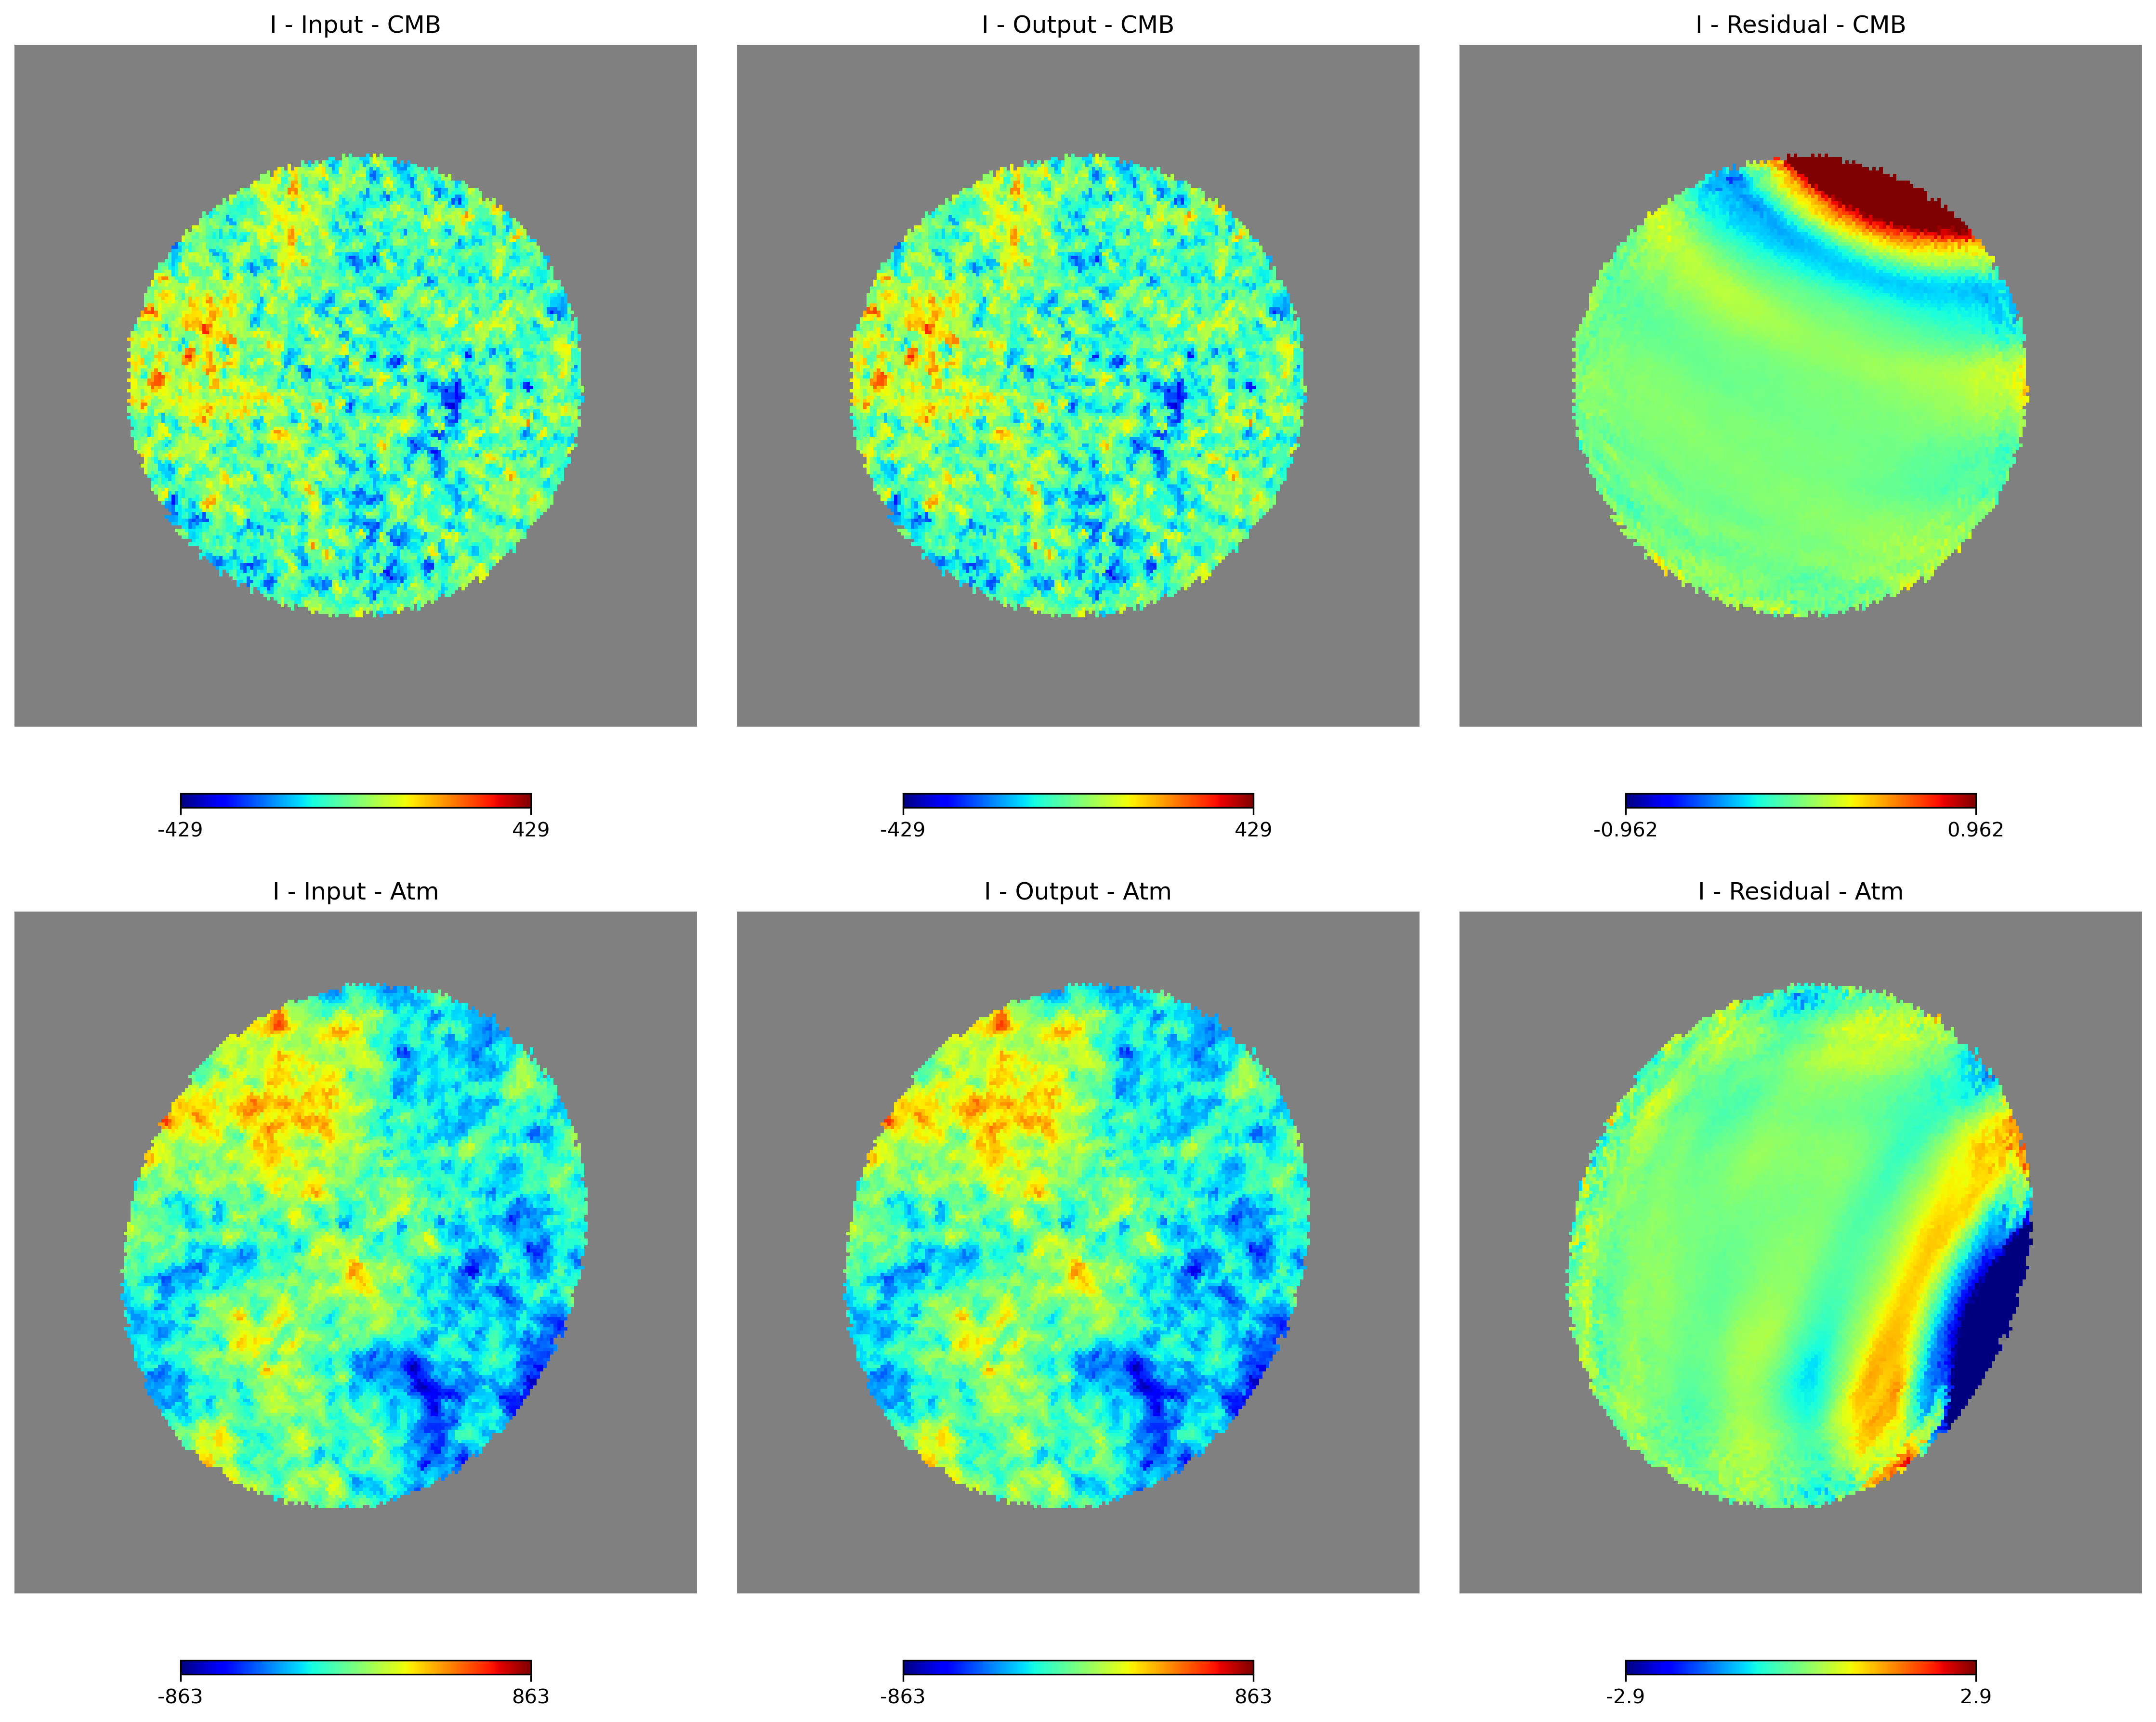

In [46]:
plt.figure(figsize=(15, 12), dpi=300)
k=1

istk = 0
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
        input[imap, ~seenpix_gal, :] = hp.UNSEEN
        output[imap, ~seenpix_gal, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal, :] = hp.UNSEEN
    else:
        map = "Atm"
        center = center_local
        input[imap, ~seenpix_local, :] = hp.UNSEEN
        output[imap, ~seenpix_local, :] = hp.UNSEEN
        residual[imap, ~seenpix_local, :] = hp.UNSEEN
        
    sigma = np.std(residual[imap, seenpix[imap], istk])
    nsigma = 3
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, min = -nsigma*sigma, max=nsigma*sigma, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

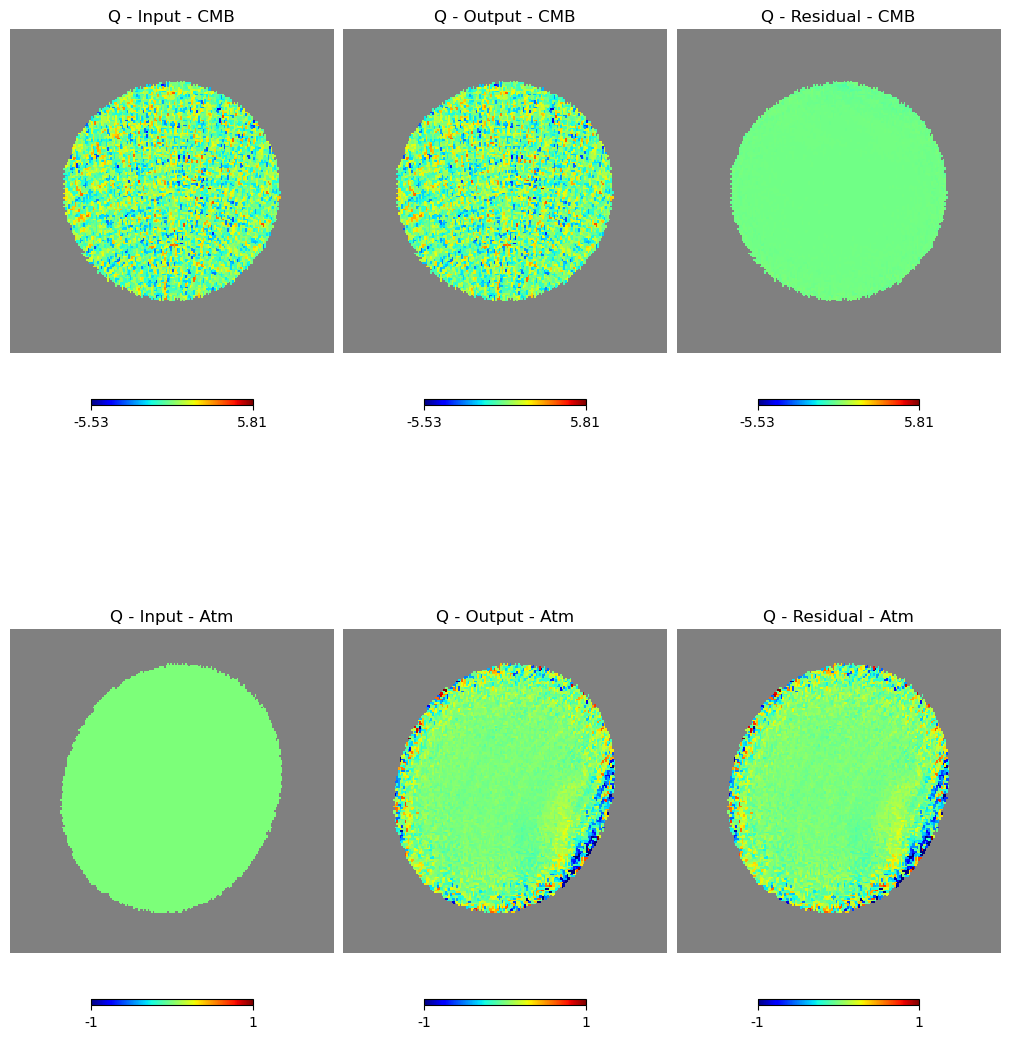

In [35]:
plt.figure(figsize=(10, 12))
k=1

istk = 1
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
    else:
        map = "Atm"
        center = center_local
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

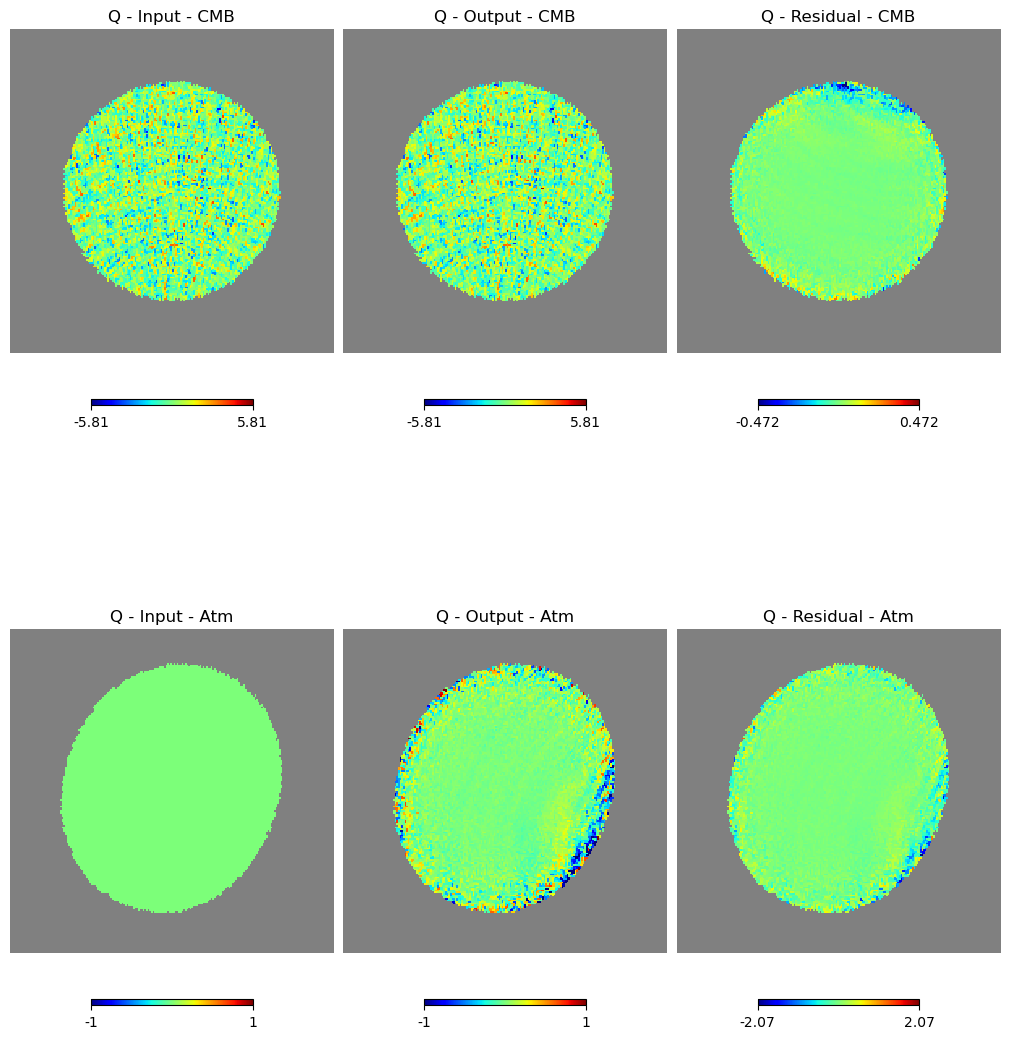

In [48]:
plt.figure(figsize=(10, 12))
k=1

istk = 1
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
        input[imap, ~seenpix_gal, :] = hp.UNSEEN
        output[imap, ~seenpix_gal, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal, :] = hp.UNSEEN
    else:
        map = "Atm"
        center = center_local
        input[imap, ~seenpix_local, :] = hp.UNSEEN
        output[imap, ~seenpix_local, :] = hp.UNSEEN
        residual[imap, ~seenpix_local, :] = hp.UNSEEN
        
    min_res = np.min(residual[imap, seenpix[imap], istk])
    max_res = np.max(residual[imap, seenpix[imap], istk])
    range_hp = np.max([-min_res, max_res])
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, min=-range_hp, max=range_hp, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()

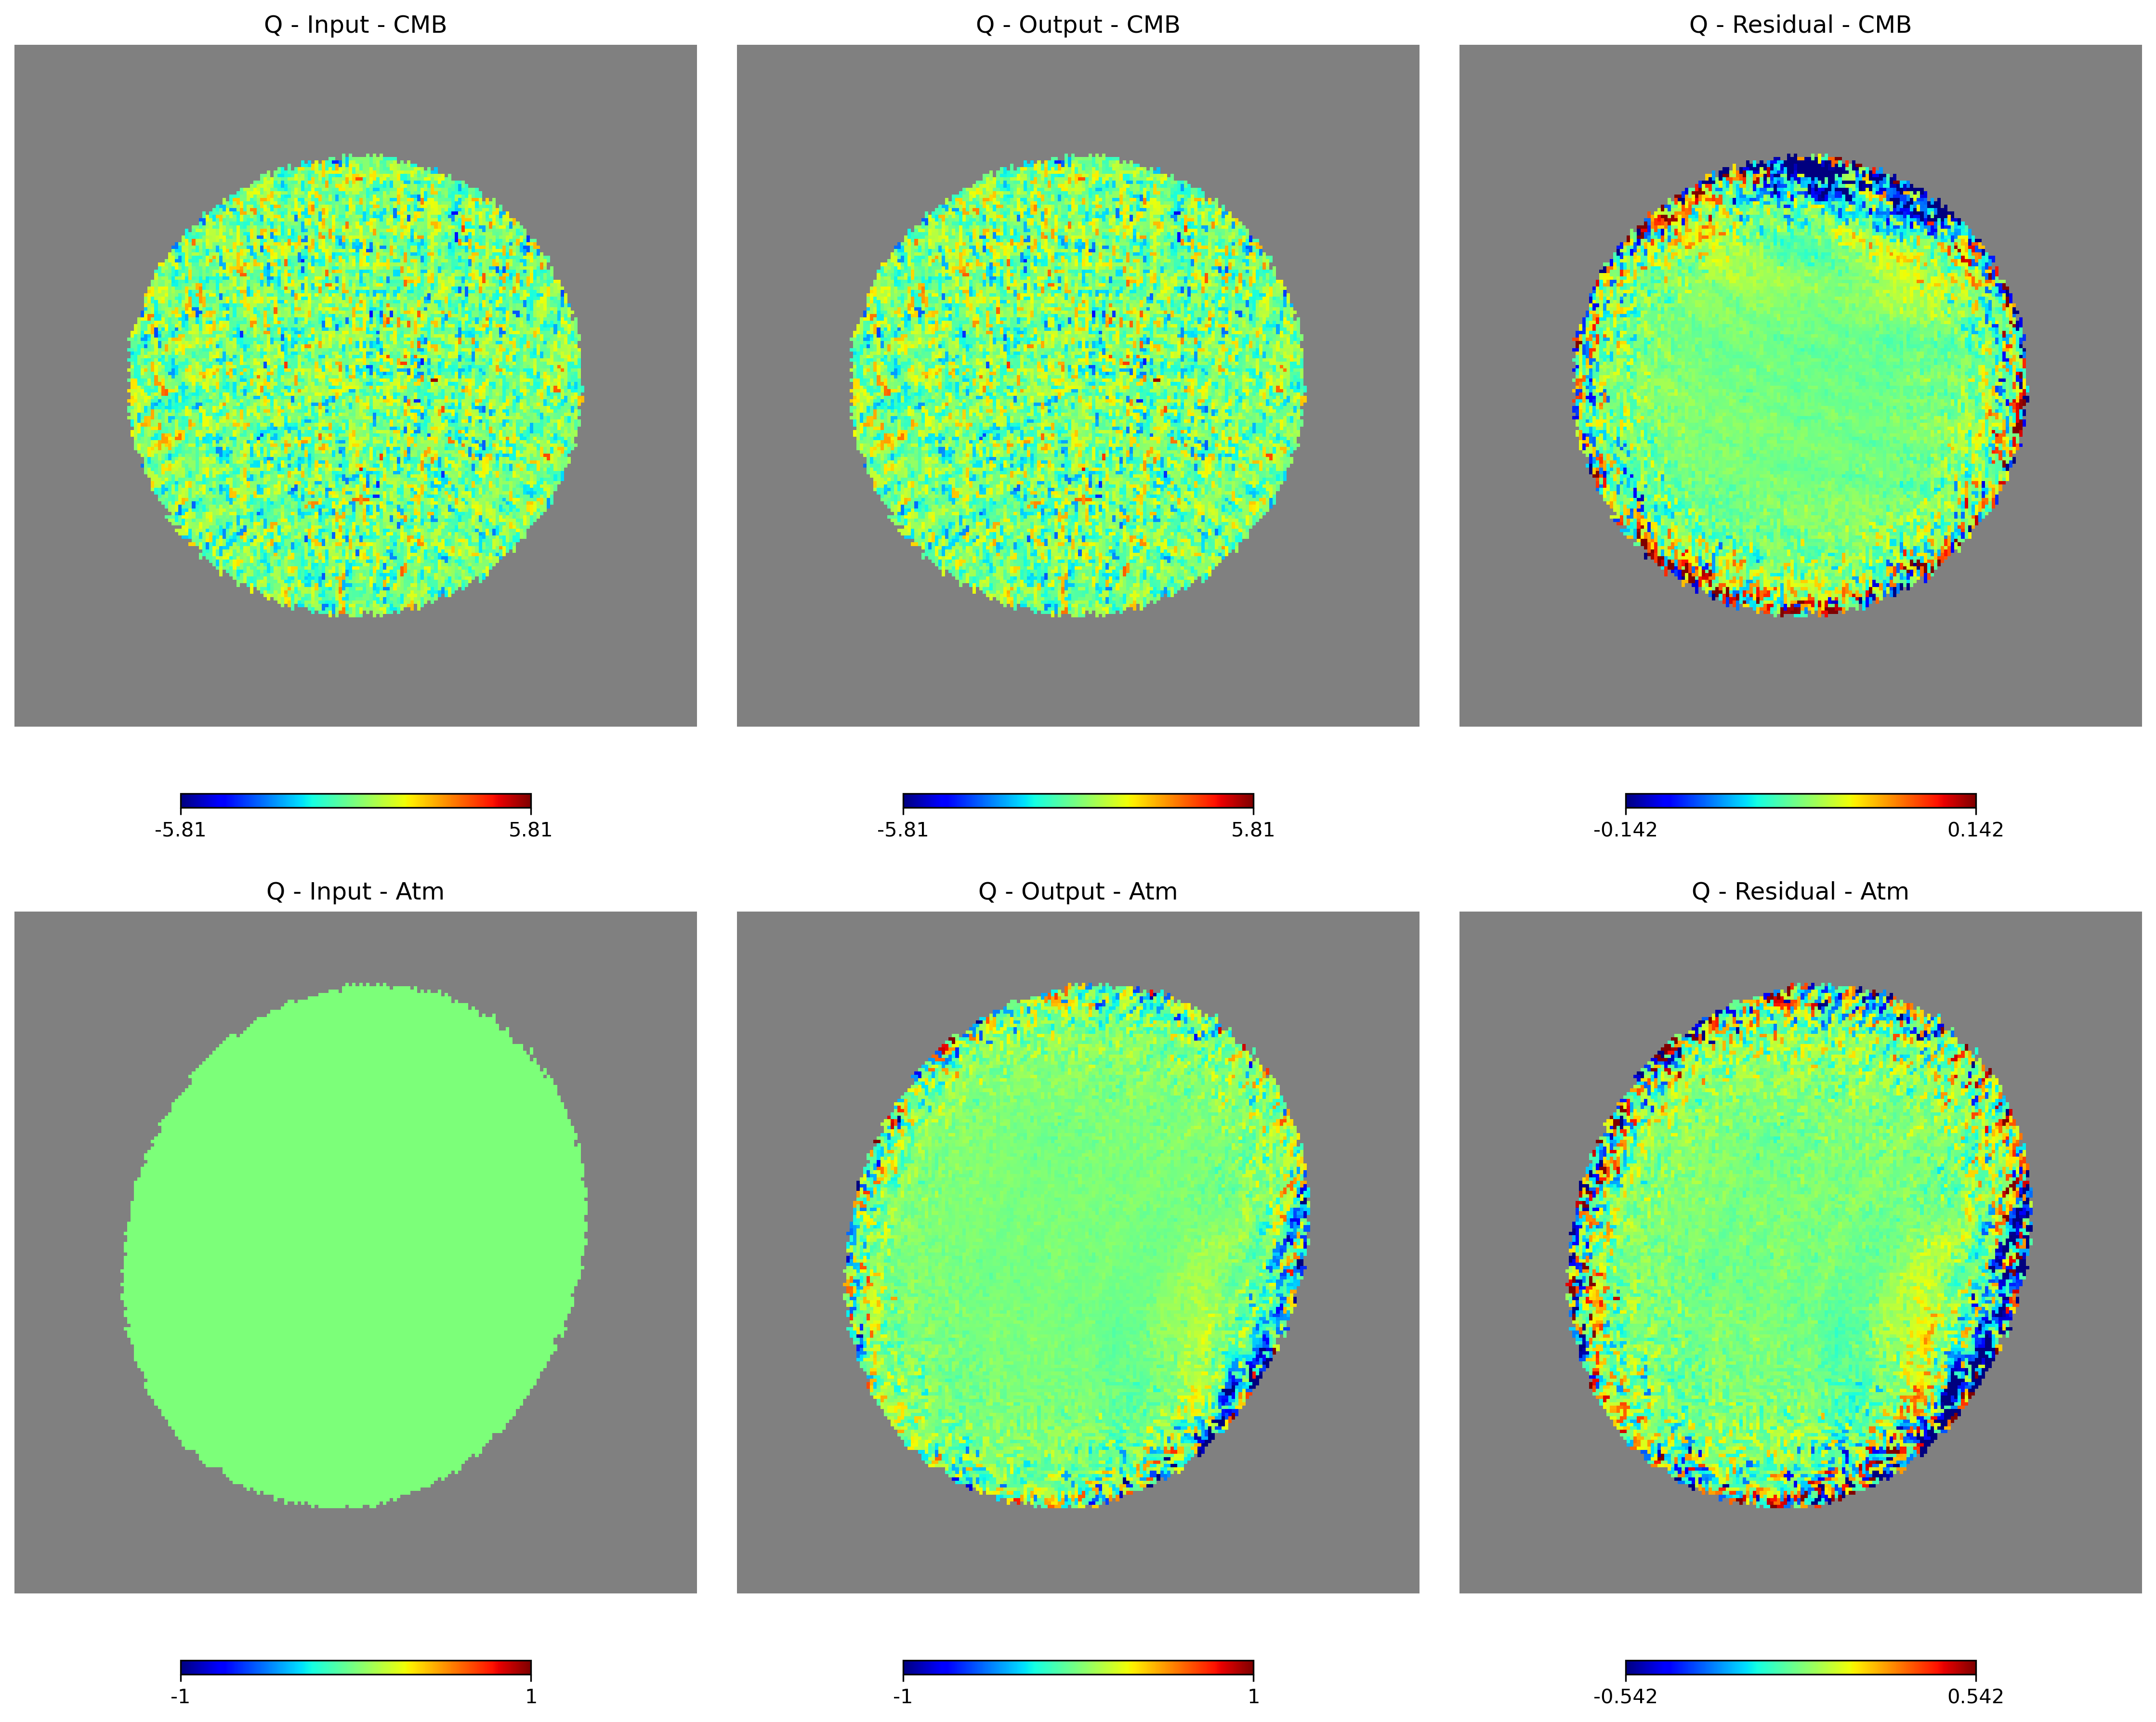

In [49]:
plt.figure(figsize=(15, 12), dpi=300)
k=1

istk = 1
stk = ['I', 'Q', 'U']

reso = 20

for imap in range(input.shape[0]):
    if imap == 0:
        map = 'CMB'
        center = center_gal
        input[imap, ~seenpix_gal, :] = hp.UNSEEN
        output[imap, ~seenpix_gal, :] = hp.UNSEEN
        residual[imap, ~seenpix_gal, :] = hp.UNSEEN
    else:
        map = "Atm"
        center = center_local
        input[imap, ~seenpix_local, :] = hp.UNSEEN
        output[imap, ~seenpix_local, :] = hp.UNSEEN
        residual[imap, ~seenpix_local, :] = hp.UNSEEN
        
    sigma = np.std(residual[imap, seenpix[imap], istk])
    nsigma = 3
    
    hp.gnomview(input[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k), title=f'{stk[istk]} - Input - {map}', notext=True)
    hp.gnomview(output[imap, :, istk],reso = reso, rot=center, min=min_input[imap, istk], max=max_input[imap, istk], cmap='jet', sub=(input.shape[0], 3, k+1), title=f'{stk[istk]} - Output - {map}', notext=True)
    hp.gnomview(residual[imap, :, istk],reso = reso, rot=center, min = -nsigma*sigma, max=nsigma*sigma, cmap='jet', sub=(input.shape[0], 3, k+2), title=f'{stk[istk]} - Residual - {map}', notext=True)
    k+=3
    
plt.tight_layout()